In [1]:
%matplotlib inline


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import xbout
import scipy
import xhermes

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *

import gridtools.solps_python_scripts.setup
from gridtools.solps_python_scripts.utilities.last10s       import read_last10s

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.solps_pp import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2

plt.close("all")
%matplotlib inline

print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


In [2]:
db = CaseDB()

toload = [ 
    dict(name="afnE_mfp1", id = "d24b-tunefrec_E_AFN_mfp1.0", unnormalise_geom = True, use_xhermes = True, squash = True),
    # dict(name="hotneut_AFN", id="hn4d-hnthresh_0_widev2_AFN", unnormalise_geom = True, use_xhermes = True, squash = True), 
    # dict(name="hotneut_AFN_nopump", id="hn4e-hnthresh_0_widev2_AFN_nopump", unnormalise_geom = True, use_xhermes = True, squash = True), 
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)


- Reading case d24b-tunefrec_E_AFN_mfp1.0
-----------------------
- Looking for squash file
- Squash file found. squash date 10/15/2023, 22:03:01, dmp file date 10/13/2023, 18:12:51

Unnormalising with xHermes


# Read SOLEDGE

In [3]:
soledgecases = {
    "tightwall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_1e19"), # Hermes-3 like wall
    "tightwall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19"), # Hermes-3 like wall
    "widewall_2e19_5m" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19_5M"),
    "tightwall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_3e19"), # Hermes-3 like wall
    "widewall_1e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_1e19"), 
    "widewall_2e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_2e19"), 
    "widewall_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\ST40_wallStd_bra_nocore_D_3e19"), 
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata(path = path)
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)
c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astyp

# Read SOLPS

In [4]:
solpscases = {
    # "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    # "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    # "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    # "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    # "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    # "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    # "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    # "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    # "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0"),
    # "16x_mc" : os.path.join(onedrive_path, r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.xxx.BCCON=16.core_extent.MC.histories.x16-ish.NOT.converged"),
    "tightwall_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19",
    "tightwall_noD2_1e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=1.0E+19.NO.D2",
    "tightwall_noD2_2e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=2.0E+19.NO.D2",
    "tightwall_noD2_3e19" : r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_tight_wall_orthogonal_MK\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.NESEPM=3.0E+19.NO.D2",
    
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    # sp[name].read_last10s(solpscases[name])
    sp[name].read_from_case(solpscases[name])

# Read Hermes-3

In [7]:
cs.keys()

dict_keys(['base_noAFN', 'base_AFN', 'base_AFN_nocondlim', 'hotneut', 'hotneut_AFN', 'hotneut_AFN_nopump'])

In [5]:
hr = dict()
for name in cs.keys(): 
    print(name)
    hr[name] = Hermesdata()
    hr[name].read_case(cs[name].ds.isel(t=-1))

    
    ds = cs[name].ds
    ds = calculate_radial_fluxes(ds, new_afn = True)
    # ds = calculate_target_fluxes(ds)
    ds = reverse_pfr_fluxes(ds)

afnE_mfp1


In [5]:
cs.keys()

dict_keys(['afnE_mfp1'])

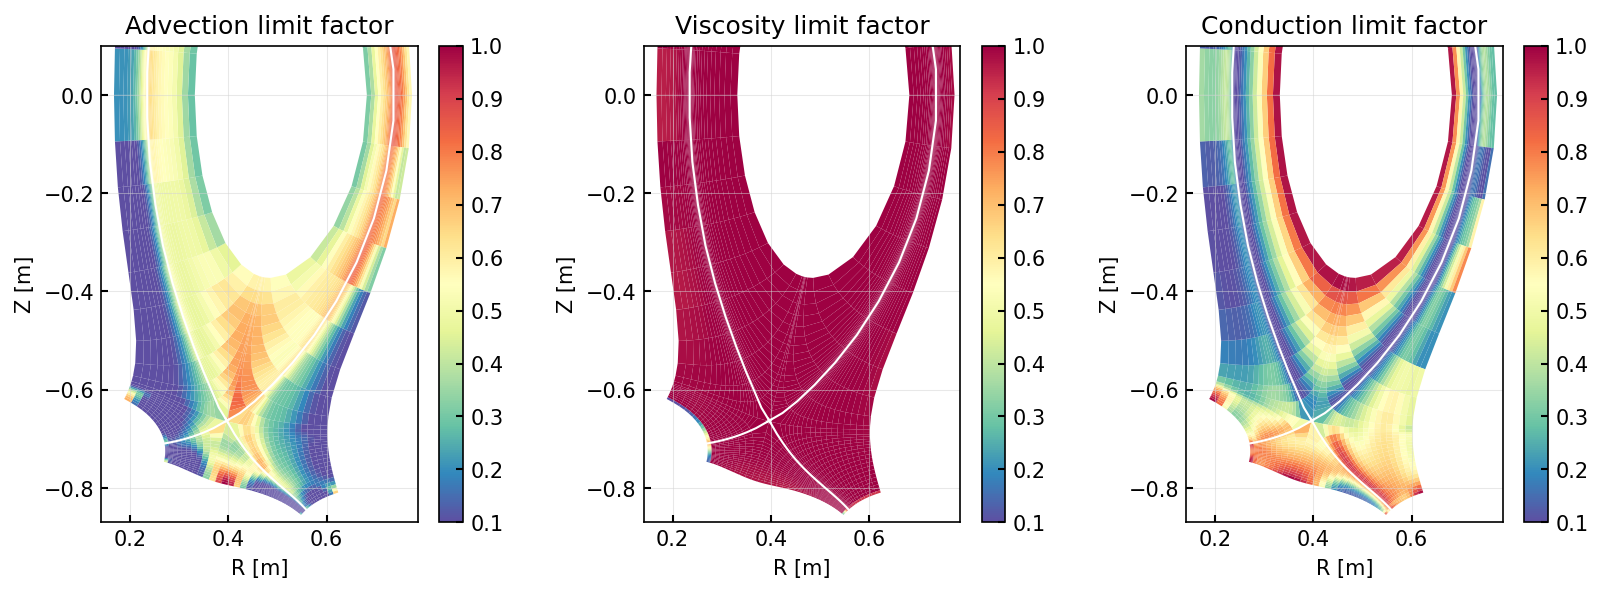

In [7]:
fig, axes = plt.subplots(1,3, dpi = 150, figsize = (11,4))

ds = cs["afnE_mfp1"].ds
if "t" in ds.dims: ds = ds.isel(t=-1)
sepkwargs = dict(linewidth = 1, color = "white", linestyle = "-")
(ds["particle_flux_factor_d"]).hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "Spectral_r", antialias = True, 
                                                            vmin = 0.1, vmax = 1, logscale = False, 
                                                            separatrix_kwargs = sepkwargs, targets = False)

(ds["momentum_flux_factor_d"]).hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "Spectral_r", antialias = True,
                                                           vmin = 0.1, vmax = 1, logscale = False, 
                                                           separatrix_kwargs = sepkwargs, targets = False)

(ds["heat_flux_factor_d"]).hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "Spectral_r", antialias = True, 
                                                            vmin = 0.1, vmax = 1, logscale = False, 
                                                            separatrix_kwargs = sepkwargs, targets = False)

axes[0].set_title("Advection limit factor")
axes[1].set_title("Viscosity limit factor")
axes[2].set_title("Conduction limit factor")

for ax in axes:
    ax.set_ylim(-0.87,0.1)
    
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(1,3, dpi = 150, figsize = (11,4))

ds = cs["afnE_mfp1"].ds
if "t" in ds.dims: ds = ds.isel(t=-1)
sepkwargs = dict(linewidth = 1, color = "white", linestyle = "-")
(ds["Pd"]).hermesm.clean_guards().bout.polygon(ax = axes[0], cmap = "Spectral_r", antialias = True, 
                                                            vmin = 0.1, vmax = 1, logscale = False, 
                                                            separatrix_kwargs = sepkwargs, targets = False)

# (ds["momentum_flux_factor_d"]).hermesm.clean_guards().bout.polygon(ax = axes[1], cmap = "Spectral_r", antialias = True,
#                                                            vmin = 0.1, vmax = 1, logscale = False, 
#                                                            separatrix_kwargs = sepkwargs, targets = False)

# (ds["heat_flux_factor_d"]).hermesm.clean_guards().bout.polygon(ax = axes[2], cmap = "Spectral_r", antialias = True, 
#                                                             vmin = 0.1, vmax = 1, logscale = False, 
#                                                             separatrix_kwargs = sepkwargs, targets = False)

axes[0].set_title("Advection limit factor")
axes[1].set_title("Viscosity limit factor")
axes[2].set_title("Conduction limit factor")

for ax in axes:
    ax.set_ylim(-0.87,0.1)
    
fig.tight_layout()